<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_TSE_2D_multi_shot_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [13]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

(TSE_2D_seq)=
# 2D TSE

In [60]:
def seq_TSE_2D_multi_shot(
    fov=(200e-3, 200e-3, 8e-3),
    Nread=42,
    Nphase=42,
    FA=torch.tensor(90 * np.pi / 180),
    FA_ref=torch.tensor(120 * np.pi / 180),
    TR=torch.tensor(5.0),
    TE=torch.tensor(5e-3),
    slice_thickness=8e-3,
    experiment_id='TSE_2D',
    system=None,
    # TSE-specific parameters
    TI_s=0, 
    PEtype='linear',
    r_spoil=2, 
    PE_grad_on=True,  
    RO_grad_on=True,  
    shots=2, 
    dumshots=0, 
    dumref=1, 
    dwell=50e-6*2
):
    """
    2D TSE multi-shot sequence function following MRzero standard.
    
    Args:
        fov[0]: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - excitation flip angle
        FA_ref: tensor - refocusing flip angle
        TR: tensor - repetition time
        TE: tensor - echo time
        slice_thickness: float - slice thickness
        experiment_id: string - experiment identifier
        system: optional scanner system limits
        TI_s: float - inversion time in seconds
        PEtype: string - phase encoding type ('centric' or 'linear')
        r_spoil: int - spoiling factor
        PE_grad_on: bool - enable phase encoding gradients
        RO_grad_on: bool - enable readout gradients
        shots: int - number of shots
        dumshots: int - number of dummy shots
        dumref: int - number of dummy refocusing pulses
        dwell: float - ADC dwell time
    
    Returns:
        pp.Sequence: PyPulseq sequence object
    """
    # Choose the scanner limits
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=10e-6
    )

    seq = pp.Sequence(system)

    # Define rf events
    rf1, gz1, gzr1 = pp.make_sinc_pulse(
        flip_angle=FA.item() * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    rf2, gz2, _ = pp.make_sinc_pulse(
        flip_angle=FA_ref.item() * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)


    G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov[0]*G_flag[0], flat_time=Nread*dwell, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=0*gx.rise_time, system=system)
    gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
    gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
    gp = pp.make_trapezoid(channel='y', area=0 / fov[0], duration=1e-3, system=system)
    rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


    if PE_grad_on:
        if PEtype == 'centric':
            phenc = np.asarray([i // 2 if i % 2 == 0 else -(i + 1) // 2 for i in range(Nphase)]) / fov[0]
        else:
            phenc = np.arange(-Nphase // 2, Nphase // 2) / fov[0]
    else:
        phenc = np.zeros((Nphase, ))

    # the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
    minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2
    minTE2=round(minTE2/10e-5)*10e-5

    # to realize longer TE,  we introduce a TEdelay that is added before and after the encoding period
    TEd=round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

    if TEd==0:
        print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
    else:
        print(' TE [ms]', 2*(minTE2 +TEd)*1000)

    TRd=0
    if dumshots+shots>1:
        TRd=TR - Nphase//shots*TE

    # seq loop starts
    for shot in range(-dumshots, shots):
        # FLAIR
        if TI_s>0:
            seq.add_block(rf_prep)
            seq.add_block(pp.make_delay(TI_s))
            seq.add_block(gx_pre0)

        seq.add_block(rf1,gz1)
        seq.add_block(gx_pre0,gzr1)

        # last timing step is to add TE/2 also between excitation and first ref pulse
        # from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
        seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

        if shot<0:
            phenc_dum=np.zeros(Nphase//shots+dumref) # add refocusing dummies
        else:
            phenc_dum=np.concatenate([np.repeat(np.nan, dumref), phenc[shot::shots]]) # add refocusing dummies

        for ii, encoding in enumerate(phenc_dum):  # e.g. -64:63
            dum_ref_flag=0
            if np.isnan(encoding): encoding = 1e-8; dum_ref_flag=1 # no pe gradient if refdummy

            gp  = pp.make_trapezoid(channel='y', area=+encoding , duration=1e-3, system=system)
            gp_ = pp.make_trapezoid(channel='y', area=-encoding, duration=1e-3, system=system)

            seq.add_block(rf2,gz2)
            seq.add_block(pp.make_delay(TEd)) # TE delay
            seq.add_block(gx_prewinder, gp)

            if shot<0 or dum_ref_flag: #added dummy shots
                seq.add_block(gx)
            else:
                seq.add_block(adc, gx)
            seq.add_block(gx_prewinder, gp_)
            seq.add_block(pp.make_delay(TEd)) # TE delay
        seq.add_block(pp.make_delay(round(TRd.item(),5)))

    # Required sequence definitions
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, 1])

    return seq


C:\Users\alyar\AppData\Local\Temp\ipykernel_12856\1303029034.py:61: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz1, gzr1 = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_12856\1303029034.py:66: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf2, gz2, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_12856\1303029034.py:76: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=0*gx.rise_time, system=system)
C:\Users\alyar\AppData\Local\Temp\ipykernel_12856\1303029034.py:80: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1

echo time set to minTE [ms] 7.4
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 46 / 46 - done


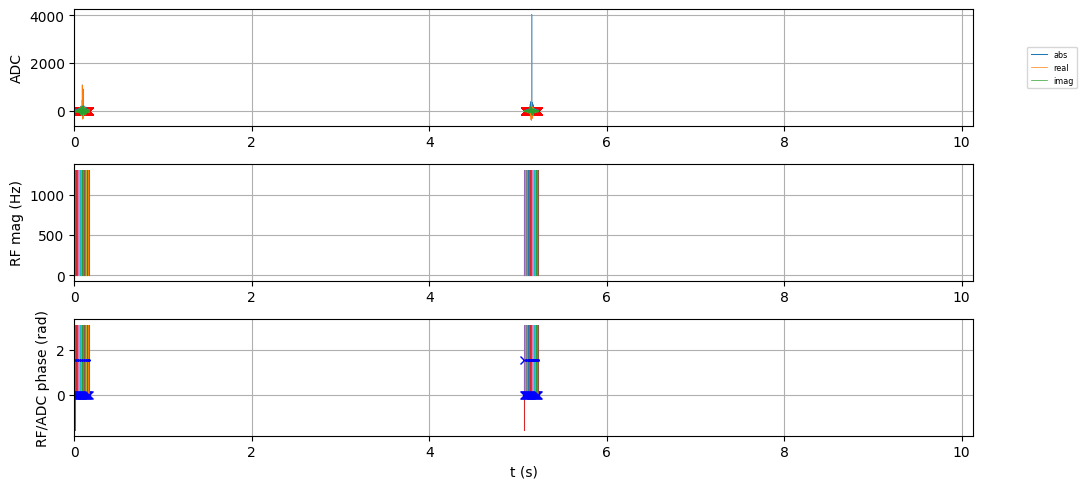

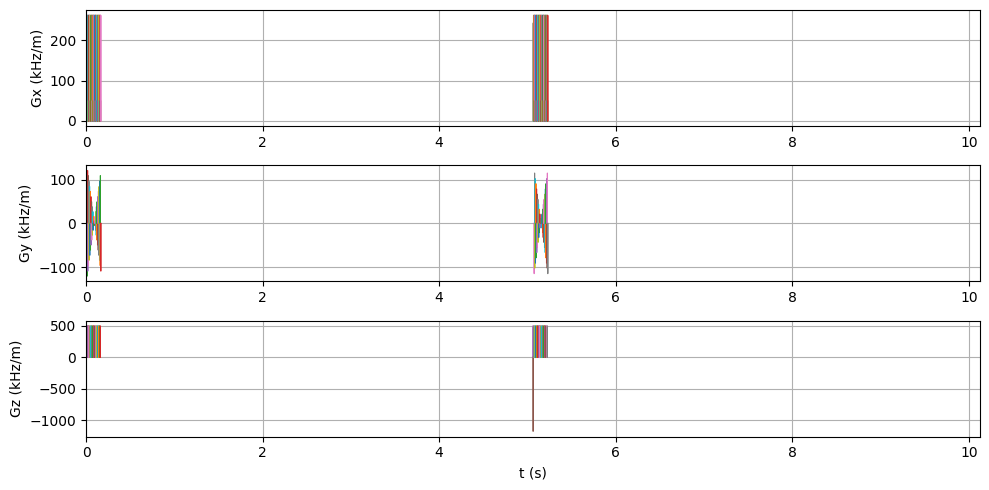

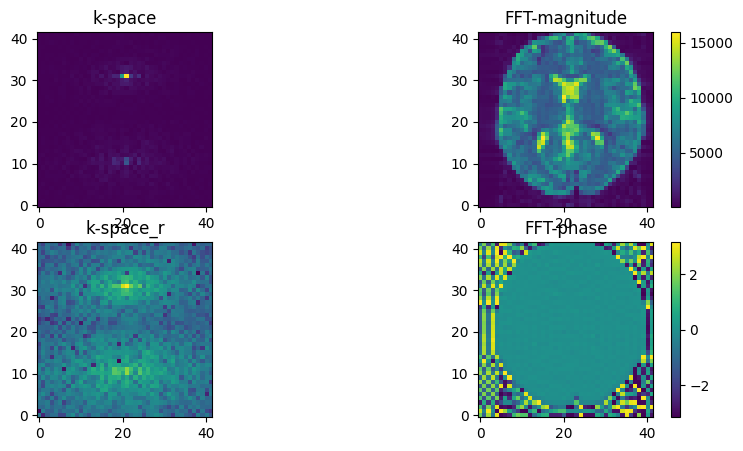

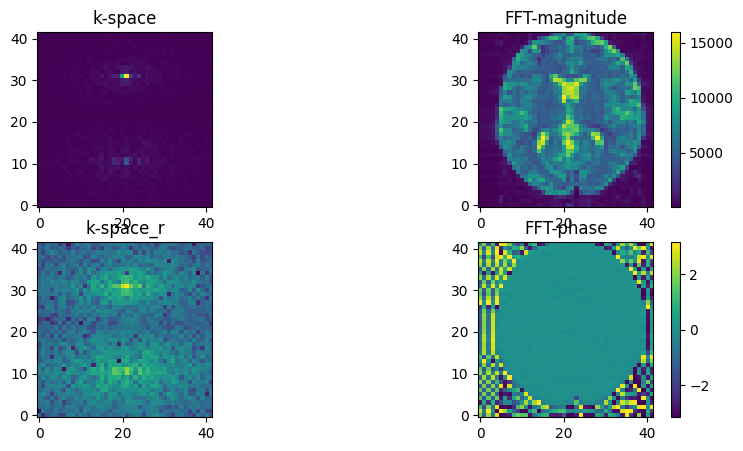

In [61]:
# Define parameters as plain variables
experiment_id = 'TSE_2D'
fov = 200e-3
slice_thickness = 8e-3


base_resolution= 42 # @param {type: "slider", min: 2, max: 112,step:2}

Nread  = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples

TE_ms=5 # @param {type: "slider", min: 0.0, max: 200.0}
TE=TE_ms*1e-3
TR=5    # @param {type: "slider", min: 0.0, max: 20}
TI_s=0 # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
Excitation_FA=90 # @param {type: "slider", min: 10, max: 270}
Refocusing_FA=120 # @param {type: "slider", min: 10, max: 270}
PEtype = 'linear' # @param ['centric', 'linear']
r_spoil =2 # @param {type: "slider", min: 0, max: 3}
PE_grad_on=True # @param {type: "boolean"}
RO_grad_on=True # @param {type: "boolean"}
shots=2     # @param {type: "slider", min: 1, max: 8}
dumshots=0  # @param {type: "slider", min: 0, max: 3}
dumref=1    # @param {type: "slider", min: 0, max: 10}
dwell = 50e-6 * 2
# Generate sequence using standard parameters
seq = seq_TSE_2D_multi_shot(
    fov=(fov,fov,slice_thickness),
    Nread=Nread,
    Nphase=Nphase,
    FA=torch.tensor(Excitation_FA),
    FA_ref=torch.tensor(Refocusing_FA),
    TR=torch.tensor(TR),
    TE=torch.tensor(TE),
    slice_thickness=slice_thickness,
    experiment_id=experiment_id,
    TI_s=TI_s,
    PEtype=PEtype,
    r_spoil=r_spoil,
    PE_grad_on=PE_grad_on,
    RO_grad_on=RO_grad_on,
    shots=shots,
    dumshots=dumshots,
    dumref=dumref,
    dwell=dwell
)

# %% S2. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()
seq.write('external.seq')
seq0 = mr0.Sequence.import_file('external.seq')

kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
reco = mr0.reco_adjoint(signal, seq0.get_kspace(), (Nread, Nphase, 1), (0.2, 0.2, 1))

# %% S4: MR IMAGE RECON of signal ::: #####################################
plt.figure()
plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))
plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(reco.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(reco.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()